In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import tensorflow as tf

In [2]:
from keras.preprocessing.image import load_img, img_to_array

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import random

In [4]:
import imgaug.augmenters as iaa

In [5]:
import cv2

In [6]:
img_width, img_height = 216, 384

In [7]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 7
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

temp_aug = iaa.ChangeColorTemperature((4000, 13000))
#help(temp_aug)
def augment_color_temperature(image):
    return temp_aug.augment_image(image.astype("uint8"))


In [8]:
aug1 = iaa.GaussianBlur(sigma=(0, 0.5))
aug2 = iaa.AdditiveGaussianNoise(scale=(0, 0.01 * 255))
transorfm_aug = iaa.PerspectiveTransform(scale=(0.001, 0.15))
affine = iaa.Affine(scale=(0.5, 1.5))

def additional_augmenation(image):
    image = aug1.augment_image(image)
    image = aug2.augment_image(image)
    #image = transorfm_aug.augment_image(image)
    #image = affine.augment_image(image)
    return image

In [9]:
def preprocess_fcn(img):
    img = add_noise(img)
    return AHE(img)

def rotate_image(img):
    img = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_LINEAR)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

In [10]:
def to_grayscale_then_rgb(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    return gray_rgb

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rescale=1./255,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.5, 2),
    validation_split=0.2,
    #vertical_flip = True,
    #horizontal_flip = True,
    #rescale = 1.0/255.0

    preprocessing_function=augment_color_temperature,
)

val = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rescale=1./255,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.5, 2),
    validation_split=0.2,
    #horizontal_flip = True,
    #rescale = 1.0/255.0

    #preprocessing_function=augment_color_temperature,
)

In [12]:
class_names = ['pelna', 'w_czesci', 'pusta']

In [13]:
my_seed = 11123

TRAIN_DIR = "../../dataset/butelka/bottle_classification/wyciete"

#train_generator = datagen.flow_from_directory('processed_dataset/nowy', batch_size=32, class_mode='categorical', seed = 123, subset='training', classes=class_names, shuffle=True)
train_generator = datagen.flow_from_directory(TRAIN_DIR, (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='training', classes=class_names, shuffle=True)
val_generator = val.flow_from_directory(TRAIN_DIR, (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='validation', classes=class_names, shuffle=True)

Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


In [14]:
from collections import Counter

print("Training")
print(train_generator.class_indices)
print(Counter(train_generator.classes))
print("Validation")
print(val_generator.class_indices)
print(Counter(val_generator.classes))

num_classes = len(class_names)

Training
{'pelna': 0, 'w_czesci': 1, 'pusta': 2}
Counter({0: 2400, 1: 2400, 2: 2400})
Validation
{'pelna': 0, 'w_czesci': 1, 'pusta': 2}
Counter({0: 600, 1: 600, 2: 600})


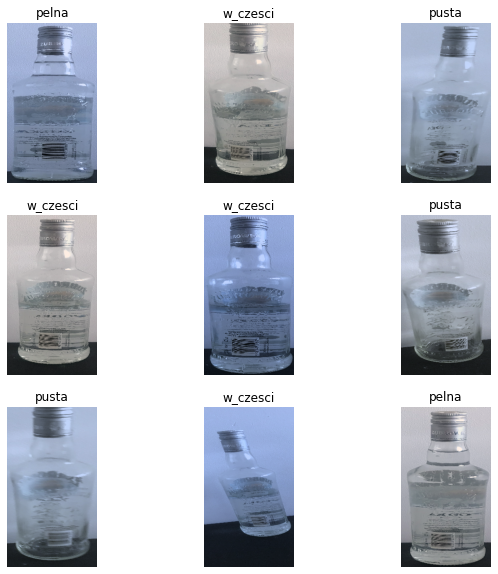

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for gen in range(3):
    x,y = train_generator.next()

    for i in range(3):
        ax = plt.subplot(3, 3, gen * 3 + i + 1)
        plt.imshow(x[i].astype("uint8"))
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")

plt.show()

In [19]:
def create_model(num_classes):

    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2, 2),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        #Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.summary()

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
    
    return model

In [20]:
model = create_model(num_classes)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 382, 214, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 191, 107, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 189, 105, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 94, 52, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 92, 50, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 24, 64)       

In [ ]:
epochs = 10

my_callbacks = [
    #tf.keras.callbacks.ModelCheckpoint(filepath='nasze.{epoch:02d}-{val_loss:.2f}.h5'),
]

history=model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
225/225 [==============================] - 147s 649ms/step - loss: 1.1532 - accuracy: 0.3693 - val_loss: 1.0314 - val_accuracy: 0.5017
Epoch 2/10
225/225 [==============================] - 147s 654ms/step - loss: 1.0936 - accuracy: 0.3954 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 3/10
225/225 [==============================] - 148s 656ms/step - loss: 1.0965 - accuracy: 0.3706 - val_loss: 1.0873 - val_accuracy: 0.3422
Epoch 4/10
225/225 [==============================] - 153s 682ms/step - loss: 0.6216 - accuracy: 0.7019 - val_loss: 0.2814 - val_accuracy: 0.8956
Epoch 5/10
225/225 [==============================] - 148s 658ms/step - loss: 0.1904 - accuracy: 0.9329 - val_loss: 0.2604 - val_accuracy: 0.8978
Epoch 6/10
225/225 [==============================] - 179s 794ms/step - loss: 0.1006 - accuracy: 0.9642 - val_loss: 0.1518 - val_accuracy: 0.9544
Epoch 7/10
114/225 [==============>...............] - ETA: 2:13 - loss: 0.0491 - accuracy: 0.9868

In [ ]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.imshow(X[0])

In [ ]:
from PIL import Image

In [ ]:
def make_prediction(src, model, show_image, expected_result):
    correct = 0
    incorrect = 0
    for root, subdirs, files in os.walk(src):
        for images in files:
            img = cv2.imread(root+images, cv2.IMREAD_UNCHANGED)[:, :, ::-1]
            img = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_LINEAR)
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            if(show_image):
                plt.imshow(img.astype("uint8"))
                plt.show()
            #img = np.array(img).astype('float32')
            #img = img / 255.0
            X_to_predict = np.expand_dims(img, axis=0)
            y_pred = model.predict(X_to_predict)[0]
            prediction_class = y_pred.argmax()
            prediction_confidence = y_pred[prediction_class]
            
            print(prediction_class)
            print(prediction_confidence)
            print(class_names[prediction_class])
            print(y_pred)
            
            if prediction_class == expected_result:
                correct = correct + 1
            else:
                incorrect = incorrect + 1
    print(f"Poprawne: {correct}, niepoprawne: {incorrect}")

print(class_names)

In [20]:
model.save('dosprawkaznowuten14.h5')

In [ ]:
from keras.models import load_model

# Do odczytu

In [ ]:
model = load_model('dosprawkaznowuten13.h5')

In [ ]:
make_prediction('../../dataset/butelka/test/w_czesci/', model, True, 1)

In [ ]:
def check_prediction(src, class_directories, model):
    for index, class_dirs in enumerate(class_directories):
        for directory_name in class_dirs:
            full_dir_name = "{src}{dir}".format(src=src, dir = directory_name)
            print("Sprawdzanie folderu '{dir_name}' jako '{class_name}'".format(dir_name = full_dir_name, class_name = class_names[index]))
            class_images = 0
            class_correct_images = 0
            for root, subdirs, files in os.walk(full_dir_name):
                for images in files:
                    img = cv2.imread(root+images, cv2.IMREAD_UNCHANGED)[:, :, ::-1]
                    img = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_LINEAR)
                    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    #img = np.array(img).astype('float32')
                    #img = img / 255.0
                    X_to_predict = np.expand_dims(img, axis=0)
                    y_pred = model.predict(X_to_predict)
                    prediction_class = y_pred.argmax()

                    if(prediction_class == index):
                        class_correct_images = class_correct_images + 1
                    class_images = class_images + 1

            print("{correct} na {total_images} było poprawny".format(correct = class_correct_images, total_images = class_images))

In [ ]:
check_prediction('../../dataset/butelka/test/', [["pelna_test/"], ['w_czesci/'], ["pusta_test/"]], model)